In [18]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

In [19]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

import util.RAVDESS_dataset_util as Rd
import multimodal_vae
from train_mvae import build_model, train

from config_args import ConfigModelArgs, ConfigTrainArgs
import torch_mvae_util as U

In [28]:
cfg_model = ConfigModelArgs()
cfg_train = ConfigTrainArgs()

face_dataset = Rd.FaceEmotionDataset(
    root_dir=cfg_model.dataset_path,
    transform=transforms.Compose
    ([
        Rd.Rescale(int(cfg_model.img_size * 1.5)), 
        Rd.CenterCrop(int(cfg_model.img_size * 1.5)), 
        Rd.ToTensor()
    ]))

trainingset_len = len(face_dataset) // 100 * 90
testset_len = len(face_dataset) - trainingset_len
training_dataset, testing_dataset = torch.utils.data.random_split(
    face_dataset, 
    [trainingset_len, testset_len],
    generator=torch.Generator().manual_seed(42)
)

dataset_loader = DataLoader(training_dataset, batch_size=cfg_train.batch_size,
                        shuffle=False, num_workers=cfg_train.num_workers)

testset_loader = DataLoader(testing_dataset, batch_size=cfg_train.batch_size,
                        shuffle=False, num_workers=cfg_train.num_workers)

print('training set size: ',trainingset_len,'\ntest set size: ',testset_len)

training set size:  8820 
test set size:  1047


torch.Size([3, 64, 64])


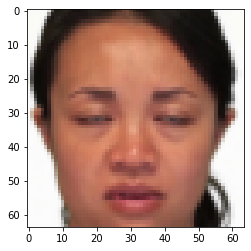

In [31]:
img = face_dataset[2]['image']
plt.imshow(np.array(img*255., dtype='uint8').transpose((1, 2, 0)))
print(img.shape)

In [ ]:
folder_path = "../trained_models/"

model_names = ["ravdess_InfoVAE_face_01.save",
               "ravdess_InfoVAE_face_02.save",
               "ravdess_InfoVAE_face_03.save",
               "ravdess_InfoVAE_face_04.save",
              ]

for model_name in model_names:
    loaded_data = torch.load(folder_path + model_name)
    model_args = loaded_data['model_args']
    train_args = loaded_data['train_args']
    losses = loaded_data['training_loss']
    
    model: torch.nn.Module = build_model(**loaded_data['model_args']).double()
    model.load_state_dict(loaded_data['model_params'])
    
    U.test_batch(model, testset_loader, num_images=4, model_eval=True)
    
    #U.print_losses(losses, model_name)
    #img = U.display_recontructed_images(model, model_eval=True)
    
    print(model_name)
    print(model_args)
    print(train_args)